In [4]:
%matplotlib inline

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import os.path
import pandas as pd
import pickle

In [6]:
import librosa as lb

In [13]:
ANNOTATIONS_ROOT = Path('Chopin_Mazurkas/annotations_beat')
query_list = Path('cfg_files/query.test.list')

# For modified files
ANNOTATIONS_ROOT_0500 = Path('Mazurkas_median_x0.500/annotations_beat')
ANNOTATIONS_ROOT_0630 = Path('Mazurkas_median_x0.630/annotations_beat')
ANNOTATIONS_ROOT_0794 = Path('Mazurkas_median_x0.794/annotations_beat')
ANNOTATIONS_ROOT_1000 = Path('Mazurkas_median_x1.000/annotations_beat')
ANNOTATIONS_ROOT_1260 = Path('Mazurkas_median_x1.260/annotations_beat')
ANNOTATIONS_ROOT_1588 = Path('Mazurkas_median_x1.588/annotations_beat')
ANNOTATIONS_ROOT_2000 = Path('Mazurkas_median_x2.000/annotations_beat')

query_list_train_toy = Path('cfg_files/filelist.train_toy.txt')
query_list_train_small = Path('cfg_files/filelist.train_small.txt')
query_list_train_medium = Path('cfg_files/filelist.train_medium.txt')
query_list_train_full = Path('cfg_files/filelist.train_full.txt')
query_list_test_full = Path('cfg_files/filelist.test_full.txt')

### Evaluate hypothesis directory

First evaluate a single hypothesis directory.

In [7]:
def eval_dir(hypdir, querylist, hop_sec, annotation_root1, annotation_root2, savefile = None):
    
    allErrs = {}
    cnt = 0
    print(f'Processing {hypdir} ', end='')
    with open(querylist, 'r') as f:
        for line in f:
            parts = line.strip().split()
            assert len(parts) == 2
            basename = os.path.basename(parts[0]) + '__' + os.path.basename(parts[1])
            hypfile = hypdir + '/' + basename + '.pkl'
            if not os.path.exists(hypfile):
                print("X", end='')
                continue
            allErrs[basename] = eval_file(hypfile, hop_sec, annotation_root1, annotation_root2)
            cnt += 1
            if cnt % 500 == 0:
                print(".", end='')
    print(' done')
    if savefile:
        pickle.dump(allErrs, open(savefile, 'wb'))
        
    return allErrs

In [8]:
def eval_file(hypfile, hop_sec, annotation_root1, annotation_root2):
    parts = os.path.basename(hypfile).split('__')
    assert len(parts) == 2
    piece = extractPieceName(parts[0])
    annotfile1 = (Path(annotation_root1) / piece / parts[0]).with_suffix('.beat')
    annotfile2 = (Path(annotation_root2) / piece / parts[1]).with_suffix('.beat')
    gt1 = getTimestamps(annotfile1)
    gt2 = getTimestamps(annotfile2)
    hypalign = loadAlignment(hypfile) # warping path in frames
    if hypalign is None:
        err = [] # no valid path
    else:
        pred2 = np.interp(gt1, hypalign[0,:]*hop_sec, hypalign[1,:]*hop_sec)
        err = pred2 - gt2
    return err

In [9]:
def extractPieceName(fullpath):
    basename = os.path.basename(fullpath) # e.g. Chopin_Op068No3_Sztompka-1959_pid9170b-21
    parts = basename.split('_')
    piece = '_'.join(parts[0:2]) # e.g. Chopin_Op068No3
    return piece

In [10]:
def getTimestamps(annotfile):
    df = pd.read_csv(annotfile, header=None, sep='\s+', skiprows=3)
    return np.array(df[0])

In [11]:
def loadAlignment(hypfile):
    with open(hypfile, 'rb') as f:
        d = pickle.load(f)
    return d

Evaluate a single hypothesis directory.

In [14]:
hypdir = 'experiments_test/train_toy.x1000.x0794.DTW1'
savefile = 'evaluations_test/train_toy.x1000.x0794.DTW1.pkl'
hop_sec = 512 * 1 / 22050
allErrs = eval_dir(hypdir, query_list_train_toy, hop_sec, ANNOTATIONS_ROOT_1000, ANNOTATIONS_ROOT_0794, savefile)

Processing experiments_test/train_toy.x1000.x0794.DTW1  done


### Plot error vs tolerance

In [15]:
def calc_error_rates(errFile, maxTol):
    
    # read from file
    with open(errFile, 'rb') as f:
        allErrs = pickle.load(f)
    
    # collect all errors
    errsFlat = []
    for query in allErrs:
        errs = np.array(allErrs[query])
        errsFlat.append(errs)
    errsFlat = np.concatenate(errsFlat)
    
    # calculate error rates
    errRates = np.zeros(maxTol+1)
    for i in range(maxTol+1):
        errRates[i] = np.mean(np.abs(errsFlat) > i/1000)
    
    return errRates, errsFlat

In [16]:
def calc_error_rates_batch(indir, basenames, maxTol):
    errRates = np.zeros((len(basenames), maxTol+1))
    allErrVals = []
    print('Computing error rates ', end='')
    for i, basename in enumerate(basenames):
        errFile = indir + '/' + basename + '.pkl'
        errRates[i,:], errors = calc_error_rates(errFile, maxTol)
        allErrVals.append(errors)
        print('.', end='')
    print(' done')
    return errRates, allErrVals

In [17]:
def plot_multiple_roc(errRates, basenames):
    numSystems = errRates.shape[0]
    maxTol = errRates.shape[1] - 1
    for i in range(numSystems):
        plt.plot(np.arange(maxTol+1), errRates[i,:] * 100.0)
    plt.legend(basenames, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Error Tolerance (ms)')
    plt.ylabel('Error Rate (%)')
    plt.show()
    return

In [18]:
EVAL_ROOT_DIR = 'evaluations_test'
toPlot = ['train_toy.x1000.x0794.DTW1'] #,'segmental_2_clean', 'segmental_4_clean', 'segmental_8_clean', 'segmental_16_clean', 'segmental_32_clean', 'pardtw_2_clean', 'pardtw_4_clean', 'pardtw_8_clean', 'pardtw_16_clean', 'pardtw_32_clean']
maxTol = 1000 # in msec
errRates, errVals = calc_error_rates_batch(EVAL_ROOT_DIR, toPlot, maxTol)

Computing error rates . done


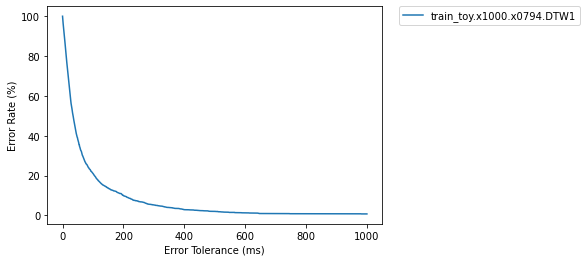

In [19]:
plot_multiple_roc(errRates, toPlot)

### Grouped barplot: 7 groups corresponding to 7 different global time warp factors

In [20]:
def get_global_time_warp(num1, num2):
    return round(num1/num2, 3)

In [21]:
def generate_df(errRates, basenames, tols):
    '''generates df to use with histogram'''
    data = []
    for i, dir in enumerate(basenames):
        info = dir.split('.')
        print(info)
        # get system
        system = info[3]
        # get global_time_warp
        factor1 = float('{}.{}'.format(info[1][1],info[1][2:]))
        factor2 = float('{}.{}'.format(info[2][1],info[2][2:]))
        global_time_warp = get_global_time_warp(factor1, factor2)
        # for tol in tols:
        for tol in tols:
            # get errors and append
            data.append((system, tol, errRates[i,tol]*100, global_time_warp))
    df = pd.DataFrame(data, columns = ['System', 'Tolerance', 'Error', 'Global Time Warp'])
    return df

In [22]:
def plot_grouped_histogram1(df):  
    # Histogram grouped by tolerance
    tol_200 = df[df['Tolerance']==200]
    sns.barplot(data=tol_200, x="Global Time Warp", y="Error", hue="System")

    plt.xlabel("Global Time Warp)", size=14)
    plt.ylabel("Error Rate", size=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid()
    plt.show()
    
    return

In [23]:
df1 = generate_df(errRates, toPlot, [200, 500, 1000])

['train_toy', 'x1000', 'x0794', 'DTW1']


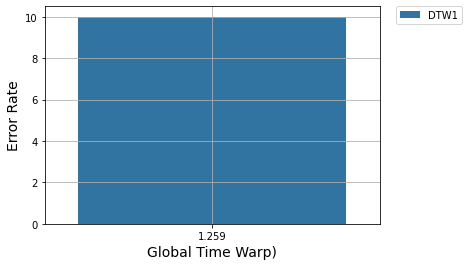

In [24]:
plot_grouped_histogram1(df1)

Evaluate all hypothesis directories.